# Exploration

In [ ]:
# Load the data as a list of lists
with open('dataset_a1.txt', 'r') as file:
    sequences = [line.strip().split(', ') for line in file]

# Example: Print the first sequence
print(sequences[0])

['Receiving Request', 'First Assessment', 'Fraud Check', 'Decline']


In [2]:
print("Type of sequences:", type(sequences))
print("Type of first sequence:", type(sequences[0]))
print("Length of sequences:", len(sequences))

print("-" * 20)

# Data is list of lists, each inner list is a sequence
# Show average length of sequences
lengths = [len(seq) for seq in sequences]
average_length = sum(lengths) / len(lengths)
print("Average length of sequences:", average_length)

print("-" * 20)

# print all potential first steps in sequences
first_steps = set()
for seq in sequences:
    first_steps.add(seq[0])
print("Potential first steps in sequences:", first_steps)

print("-" * 20)

# print all potential second steps in sequences
second_steps = set()
for seq in sequences:
    if len(seq) > 1:  # check if there is a second step
        second_steps.add(seq[1])

print("Potential second steps in sequences:", second_steps)

print("-" * 20)

# print all potential third steps in sequences
third_steps = set()
for seq in sequences:
    if len(seq) > 2:  # check if there is a third step
        third_steps.add(seq[2])

print("Potential third steps in sequences:", third_steps)

print("-" * 20)

# print all potential fourth steps in sequences
fourth_steps = set()
for seq in sequences:
    if len(seq) > 3:  # check if there is a fourth step
        fourth_steps.add(seq[3])

print("Potential fourth steps in sequences:", fourth_steps)

print("-" * 20)

# print all potential last steps in sequences\
last_steps = set()
for seq in sequences:
    last_steps.add(seq[-1])
print("Potential last steps in sequences:", last_steps)

print("-" * 20)

# print all potential steps in sequences 
all_steps = set()
for seq in sequences:
    for step in seq:
        all_steps.add(step)
print("Potential steps in sequences:", all_steps)

print("-" * 20)

# print all potential steps in sequences with their counts
step_counts = {}
for step in all_steps:
    step_counts[step] = 0
for seq in sequences:
    for step in seq:
        step_counts[step] += 1

# order step_counts by count
step_counts = dict(sorted(step_counts.items(), key=lambda item: item[1], reverse=True))
print("Potential steps in sequences with their counts:", step_counts)

print("-" * 20)

# print all potential steps in sequences not using first or last steps
not_first_last_steps = set()
for seq in sequences:
    for step in seq[1:-1]:
        not_first_last_steps.add(step)
print("Potential steps in sequences not using first or last steps:", not_first_last_steps) 

print("-" * 20)

# print number of unique steps in sequences
print("Number of unique steps in sequences:", len(all_steps))

Type of sequences: <class 'list'>
Type of first sequence: <class 'list'>
Length of sequences: 100
--------------------
Average length of sequences: 6.03
--------------------
Potential first steps in sequences: {'Receiving Request'}
--------------------
Potential second steps in sequences: {'First Assessment'}
--------------------
Potential third steps in sequences: {'Fraud Check'}
--------------------
Potential fourth steps in sequences: {'Fraud Check', 'Decline', 'Accept'}
--------------------
Potential last steps in sequences: {'Decline', 'Offer Refused', 'Fraud Check', 'First Assessment', 'Send Contract', 'Receiving Request'}
--------------------
Potential steps in sequences: {'Contact Customer', 'Decline', 'Offer Refused', 'Draw Contract', 'Fraud Check', 'First Assessment', 'Send Contract', 'Accept', 'Receiving Request', 'Create Offer'}
--------------------
Potential steps in sequences with their counts: {'Fraud Check': 174, 'Receiving Request': 100, 'First Assessment': 95, 'Declin

# Use of support.py

In [3]:
import numpy as np
import os

import contextlib
import pandas as pd
from datetime import date, datetime

from pm4py.objects.petri_net.obj import PetriNet
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to
from pm4py.objects.petri_net.obj import Marking
from pm4py import conformance
from pm4py.utils import constants

constants.SHOW_PROGRESS_BAR = False

activities = [
    "Invisible 1",
    "Invisible 2",
    "Receiving Request",
    "First Assessment",
    "Fraud Check",
    "Accept",
    "Decline",
    "Create Offer",
    "Contact Customer",
    "Offer Refused",
    "Draw Contract",
    "Send Contract",
]

NR_PLACES = 9

# loads and prepares the dataset for fitness evaluations
def load_dataset(path):
    res = []
    with open(path) as fi:
        for line in fi:
            res.append(line.strip().split(", "))

    # reformating the dataset to a pandas dataframe for pm4py compatibility
    df = pd.DataFrame(
        {
            "date": date.today(),
            "case:concept:name": [str(i) for i in range(len(res))],
            "concept:name": res,
        }
    )
    df["date"] = pd.to_datetime(df["date"])
    df = df.explode("concept:name")

    base_timestamp = datetime.now()
    df["time:timestamp"] = base_timestamp + pd.to_timedelta(df.index, unit="h")

    return df


DATASET = load_dataset("dataset_a1.txt")
NR_TRANSITIONS = len(activities)
NAMES_TO_TRANSITION = dict(zip(activities, range(NR_TRANSITIONS)))


def fitness(sol):
    matrix = list_to_array(sol)

    nr_violations = _get_nr_handcrafted_violations(matrix)
    alignment_score = _get_alignment_scores(matrix)
    return (alignment_score - nr_violations,)


def list_to_array(sol):
    return np.array(sol).reshape((NR_TRANSITIONS, 2))


def _get_nr_handcrafted_violations(matrix) -> int:
    nr_arrivals_to_first_place = (matrix[:, 1] == 0).sum()
    nr_departures_from_last_place = (matrix[:, 0] == NR_PLACES - 1).sum()
    nr_self_loops = (matrix[:, 0] == matrix[:, 1]).sum()
    nr_backwards_invisible = (matrix[:2, 0] > matrix[:2, 1] + 2).sum()
    nr_backwards_visible = (matrix[2:, 0] > matrix[2:, 1]).sum()

    return (
        nr_arrivals_to_first_place
        + nr_departures_from_last_place
        + nr_self_loops
        + nr_backwards_invisible
        + nr_backwards_visible
    )


def _get_alignment_scores(matrix) -> float:
    net, initial_marking, final_marking = matrix_to_petrinet(matrix)

    # Needed to redirect the output of the fitness_alignments function, which outputs a lot of text,
    with open(os.devnull, "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            try:
                fa = conformance.fitness_alignments(
                    log=DATASET,
                    petri_net=net,
                    initial_marking=initial_marking,
                    final_marking=final_marking,
                )
            except Exception as e:
                return -1

    alignment_score = fa["average_trace_fitness"]
    return alignment_score


# plot the Petri net
def sol_to_graphviz(sol, output_file="output.pdf"):
    matrix = list_to_array(sol)
    net, _, _ = matrix_to_petrinet(matrix)
    parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"}
    gviz = pn_visualizer.apply(net, parameters=parameters)
    pn_visualizer.save(gviz, output_file)


def matrix_to_petrinet(matrix):
    net = PetriNet("PETRINAS")

    places_dict = {}

    for place_nr in range(NR_PLACES):
        place = PetriNet.Place(name=f"p{place_nr}")
        net.places.add(place)
        places_dict[place_nr] = place

        if place_nr == 0:
            first_marking = Marking()
            first_marking[place] = 1

        if place_nr >= NR_PLACES - 1:
            last_marking = Marking()
            last_marking[place] = 1

    for row, activity in enumerate(activities):
        if activity.startswith("Invisible"):
            transition = PetriNet.Transition(name=activity)
        else:
            transition = PetriNet.Transition(name=activity, label=activity)
        net.transitions.add(transition)

        start, end = matrix[row]

        start_place = places_dict[start]
        add_arc_from_to(start_place, transition, net)

        end_place = places_dict[end]
        add_arc_from_to(transition, end_place, net)

    return net, first_marking, last_marking


In [4]:
data = load_dataset("dataset_a1.txt")

In [5]:
data

,date,case:concept:name,concept:name,time:timestamp
0,2025-04-25,0,Receiving Request,2025-04-25 13:19:36.907671
0,2025-04-25,0,First Assessment,2025-04-25 13:19:36.907671
0,2025-04-25,0,Fraud Check,2025-04-25 13:19:36.907671
0,2025-04-25,0,Decline,2025-04-25 13:19:36.907671
1,2025-04-25,1,Receiving Request,2025-04-25 14:19:36.907671
...,...,...,...,...
99,2025-04-25,99,Accept,2025-04-29 16:19:36.907671
99,2025-04-25,99,Create Offer,2025-04-29 16:19:36.907671
99,2025-04-25,99,Contact Customer,2025-04-29 16:19:36.907671
99,2025-04-25,99,Draw Contract,2025-04-29 16:19:36.907671


## MADE WITH AI

c:\Users\20193217\AppData\Local\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\20193217\AppData\Local\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


--- GA Parameters ---
Population Size (POP_SIZE): 100
Crossover Probability (CXPB): 0.7
Mutation Probability (MUTPB): 0.2
Number of Generations (NGEN): 20
Tournament Size (TOURNSIZE): 3
Attribute Mutation Probability (INDPB): 0.1
---------------------

gen	nevals	max     	avg     	min	std    
0  	100   	-3.52986	-9.74653	-18	2.76199
1  	74    	-0.714286	-7.48453	-13	2.42209
2  	80    	-0.693618	-5.49354	-10	2.23645
3  	77    	0.204863 	-3.97778	-10	2.03905
4  	72    	0.22738  	-2.68382	-8 	1.61654
5  	88    	0.395237 	-1.59505	-6 	1.26208
6  	74    	0.395237 	-0.908345	-7 	1.11393
7  	80    	0.432851 	-0.294383	-5 	0.939146
8  	71    	0.415111 	0.0484539	-2.77958	0.598818
9  	81    	0.415906 	0.0776138	-3.64823	0.656107
10 	77    	0.538094 	0.127616 	-4      	0.716472
11 	76    	0.43578  	0.124063 	-2.88838	0.587897
12 	82    	0.43578  	0.0269761	-3.74345	0.857255
13 	76    	0.538094 	0.124125 	-5      	0.860211
14 	68    	0.538094 	0.172917 	-4.72695	0.843076
15 	73    	0.538094 	0.20

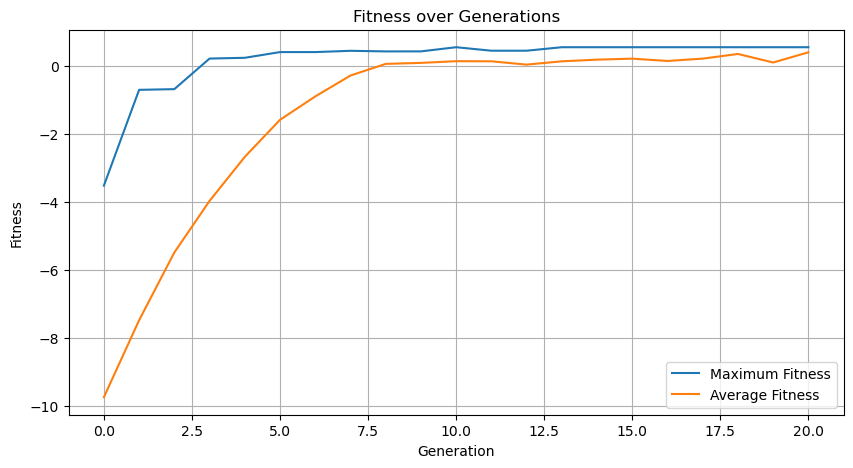

In [8]:
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np

# Ensure necessary variables from the previous cell are available
# NR_TRANSITIONS, NR_PLACES, fitness, list_to_array, sol_to_graphviz

# --- DEAP Setup ---

# Create Fitness and Individual types
# Maximize the fitness score (alignment_score - nr_violations)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator: A random integer representing a place number
toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1)

# Structure initializers
# Individual: list of NR_TRANSITIONS * 2 integers (start_place, end_place for each transition)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
# Population: list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# --- Genetic Operators ---
# Register the operators using the ones provided in support.py or defined above
toolbox.register("evaluate", fitness) # Use the fitness function
toolbox.register("mate", tools.cxTwoPoint) # Crossover
# Mutation: Mutate an attribute by replacing it with a random integer between 0 and NR_PLACES-1
# indpb: probability for each attribute to be mutated
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES - 1, indpb=0.1)
# Selection: Tournament selection
toolbox.register("select", tools.selTournament, tournsize=3)

# --- GA Parameters (Default Values) ---
POP_SIZE = 100
CXPB = 0.7       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
NGEN = 20        # Number of Generations
TOURNSIZE = 3    # Tournament Size (already set in selTournament registration)
INDPB = 0.1      # Independent probability for attributes mutation (already set in mutUniformInt registration)

print("--- GA Parameters ---")
print(f"Population Size (POP_SIZE): {POP_SIZE}")
print(f"Crossover Probability (CXPB): {CXPB}")
print(f"Mutation Probability (MUTPB): {MUTPB}")
print(f"Number of Generations (NGEN): {NGEN}")
print(f"Tournament Size (TOURNSIZE): {TOURNSIZE}")
print(f"Attribute Mutation Probability (INDPB): {INDPB}")
print("---------------------\n")

# --- Statistics ---
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

# --- Run GA ---
pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual

# Run the Simple Evolutionary Algorithm
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

# --- Results ---
best_ind = hof[0]
print("\n--- Best Individual Found ---")
print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

# Convert best individual to matrix format for inspection/visualization
best_matrix = list_to_array(best_ind)
print("\nBest Matrix:")
print(best_matrix)



# --- Plotting ---
gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Optional: Visualize the best Petri net found
try:
    output_filename = "best_petri_net.pdf"
    sol_to_graphviz(best_ind, output_file=output_filename)
    print(f"\nBest Petri net saved to {output_filename}")
except Exception as e:
    print(f"\nCould not generate graphviz plot: {e}")
    print("Ensure graphviz is installed and in your system's PATH.")


Best Petri net saved to best_petri_net.pdf
